In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import time
from module.lib.layers_opt import *
import pandas as pd
import cv2
import glob
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.size"]=18

In [10]:
class MNISTDifferentialDetector(tf.keras.layers.Layer):
    def __init__(self, output_dim, inverse=False, activation=None, normalization=None, **kwargs):
        super(MNISTDifferentialDetector, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.inverse = inverse
        self.activation = activation
        self.normalization = normalization

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "inverse": self.inverse,
            "activation": self.activation,
            "normalization": self.normalization
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
    @staticmethod
    def make_positive_filter(input_shape):
        width = int(input_shape[-1]/10)
        height = min(int(input_shape[-2]/2/5), width)
        pad_width = int(np.round(width/2))
        pad_height = int(np.round((input_shape[-1]/2-height*3)/2))


        w0 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w0[pad_height:pad_height + height, pad_width:pad_width + width] = 1.0
        w0 = tf.constant(w0)

        w1 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w1[pad_height:pad_height + height, pad_width + width*2:pad_width + width*3] = 1.0
        w1 = tf.constant(w1)

        w2 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w2[pad_height:pad_height + height, pad_width + width*4:pad_width + width*5] = 1.0
        w2 = tf.constant(w2)

        w3 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w3[pad_height:pad_height + height, pad_width + width*6:pad_width + width*7] = 1.0
        w3 = tf.constant(w3)

        w4 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w4[pad_height:pad_height + height, pad_width + width*8:pad_width + width*9] = 1.0
        w4 = tf.constant(w4)

        w5 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w5[pad_height + height*2:pad_height + height*3, pad_width:pad_width + width] = 1.0
        w5 = tf.constant(w5)

        w6 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w6[pad_height + height*2:pad_height + height*3, pad_width + width*2:pad_width + width*3] = 1.0
        w6 = tf.constant(w6)

        w7 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w7[pad_height + height*2:pad_height + height*3, pad_width + width*4:pad_width + width*5] = 1.0
        w7 = tf.constant(w7)

        w8 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w8[pad_height + height*2:pad_height + height*3, pad_width + width*6:pad_width + width*7] = 1.0
        w8 = tf.constant(w8)

        w9 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w9[pad_height + height*2:pad_height + height*3, pad_width + width*8:pad_width + width*9] = 1.0
        w9 = tf.constant(w9)

        return tf.stack([w0, w1, w2, w3, w4, w5, w6, w7, w8, w9], axis=-1)

    @staticmethod
    def make_negative_filter(input_shape):
        width = int(input_shape[-1]/10)
        height = min(int(input_shape[-2]/2/5), width)

        margin_height = int(input_shape[-2]/2)

        pad_width = int(np.round(width/2))
        pad_height = int(np.round((input_shape[-1]/2-height*3)/2)) + margin_height


        w0 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w0[pad_height:pad_height + height, pad_width:pad_width + width] = 1.0
        w0 = tf.constant(w0)

        w1 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w1[pad_height:pad_height + height, pad_width + width*2:pad_width + width*3] = 1.0
        w1 = tf.constant(w1)

        w2 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w2[pad_height:pad_height + height, pad_width + width*4:pad_width + width*5] = 1.0
        w2 = tf.constant(w2)

        w3 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w3[pad_height:pad_height + height, pad_width + width*6:pad_width + width*7] = 1.0
        w3 = tf.constant(w3)

        w4 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w4[pad_height:pad_height + height, pad_width + width*8:pad_width + width*9] = 1.0
        w4 = tf.constant(w4)

        w5 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w5[pad_height + height*2:pad_height + height*3, pad_width:pad_width + width] = 1.0
        w5 = tf.constant(w5)

        w6 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w6[pad_height + height*2:pad_height + height*3, pad_width + width*2:pad_width + width*3] = 1.0
        w6 = tf.constant(w6)

        w7 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w7[pad_height + height*2:pad_height + height*3, pad_width + width*4:pad_width + width*5] = 1.0
        w7 = tf.constant(w7)

        w8 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w8[pad_height + height*2:pad_height + height*3, pad_width + width*6:pad_width + width*7] = 1.0
        w8 = tf.constant(w8)

        w9 = np.zeros((input_shape[-2], input_shape[-1]), dtype='float32')
        w9[pad_height + height*2:pad_height + height*3, pad_width + width*8:pad_width + width*9] = 1.0
        w9 = tf.constant(w9)

        return tf.stack([w0, w1, w2, w3, w4, w5, w6, w7, w8, w9], axis=-1)

    @staticmethod
    def plot(input_shape):
        positive = MNISTDifferentialDetector.make_positive_filter(input_shape)
        negative = MNISTDifferentialDetector.make_negative_filter(input_shape)
        image = tf.reduce_sum(positive, axis=-1) + -1*tf.reduce_sum(negative, axis=-1)
        plt.imshow(image)


    def build(self, input_shape):
        self.input_dim = input_shape
        self.positive_filter = self.make_positive_filter(input_shape)
        self.negative_filter = self.make_negative_filter(input_shape)

    def call(self, x, **kwargs):
        y_positive = tf.tensordot(x, self.positive_filter, axes=[[1, 2], [0, 1]])
        y_negative = tf.tensordot(x, self.negative_filter, axes=[[1, 2], [0, 1]])

        y = y_positive - y_negative

        if self.normalization == 'minmax':
            maximum = tf.reduce_max(y)
            minimum = tf.reduce_min(y)
            y = (y - minimum) / (maximum - minimum)

        if self.activation == 'softmax':
            y = tf.nn.softmax(y)

        return y

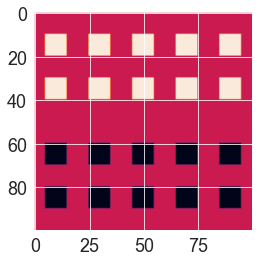

In [11]:
MNISTDifferentialDetector.plot((100, 100))

In [15]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [16]:
#@title デフォルトのタイトル テキスト
wavelength = 532.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}

In [22]:
def create_model(**kwargs):
    tf.random.set_seed(kwargs["seed"])
    shape = (28, 28)
    inputs = tf.keras.Input((28, 28))
    theta = -2.79 * np.pi / 180
    eta = np.arctan(1.24 * np.pi/180)/2
    l1=0
    print(kwargs)
    x = ImageResizing(shape)(inputs)
    x = ImageBinarization(0.5, 0.0, 1.0)(x)
    x = IntensityToElectricField(shape)(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta)(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=0.7e-3, d=d, n=1.51, method='expand')(x)
    # x = Polarizer(shape)(x)
    #x =ElectricFieldToIntensity(shape)(x)
    #x = MNISTFilter(shape)(x)
    x = FaradayRotationByStokes(shape)(x)
    # x = Argument(shape)(x)
    x = MNISTDetector(10)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [23]:
model = create_model(seed=1)

{'seed': 1}


In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

result = model.fit(x_train,
                   y_train,
                   batch_size=64,
                   epochs=20,
                   validation_data=(x_val, y_val),
                   )

Epoch 1/20


2022-07-26 19:00:48.388758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 12/860 [..............................] - ETA: 6:02 - loss: 2.3017 - accuracy: 0.1471

KeyboardInterrupt: 

/var/folders/dq/z_0g0_d101gg2c_06s9yqp8h0000gn/T/ipykernel_46065/486659569.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


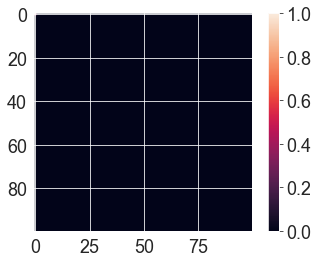

In [12]:
g = np.ones((100, 100))
G = np.fft.ifft2(g)
plt.imshow(np.abs(G))
plt.colorbar()


In [13]:
np.abs(G)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])